In [2]:

# CELDA 1 - Imports y carga
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "/content/sample_data/combined.json"

with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

df = pd.DataFrame(raw)
print("Filas, columnas:", df.shape)
df.head(5)


Filas, columnas: (18, 31)


,FECHA_DOCUMENTO,DIRECCION,MODELO_HOMOLOGADO_ANT,SUBSIDIO,AÑO,SUBTOTAL,CLASE,TOTAL,CILINDRAJE,MODELO,...,COMBUSTIBLE,EJES,TIPO,IVA,CONCESIONARIA,TONELAJE,VIN_CHASIS,PAIS_ORIGEN,ETIQUETA,_file
0,26/05/2016,"COOPERATIVA PACO OÑATE VILLA3 MANZANA C, GUAYA...",None,NaN,NaN,15982.14,AUTOMOVIL,17900.0,1.398 CC,SAIL AC 1.4 4P 4X2 TM,...,GASOLINA,2.0,SEDAN,1917.86,AUTOMOTORES CONTINENTAL S.A.,0.370,None,ECUADOR,COMPLETA,363159399-FACTURA-002-100-000001911-1.pdf
1,29/12/2018,URBANIZACION LA ROMADERA 5TA ETAPA SOLAR25 MAN...,D-MAX CRDI 3.0 CD 4X2 TM DIESEL,0.0,NaN,28003.57,CAMIONETA,31364.0,2.999 CC,D-MAX CRDI 3.0 CD 4X2 TM DIESEL,...,DIESEL,NaN,DOBLE CABINA,3360.43,AUTOMOTORES CONTINENTAL S.A.,1.250,None,None,COMPLETA,440281304-Factura-vehiculo.pdf
2,21/10/2009,Benalcázar sin Espejo,None,NaN,2009.0,25810.96,CAMION,30400.0,3900 c.c.,HD72 CHASIS CABINADO,...,DIESEL,NaN,CAMION,3257.14,HYUNDAI DEL ECUADOR HYUNDEC SOCIEDAD ANONIMA,2.800,KMFGA17BP9C900561,ECUADOR,COMPLETA,447472569-FACTURA-MM025.pdf
3,20/03/2017,AV. SAN JORGE 0426 PB 10MA CALLE AV. OLIMPO KE...,None,0.0,2016.0,35086.84,CAMIONETA,39999.0,None,AMAROK BI-TDI 2HBA34 AC 2.0 CD 4X4 TM DIESEL,...,DIESEL,NaN,DOBLE CABINA,0.00,INDUWAGEN S.A.,NaN,WV1ZZZ2HZGA027436,None,COMPLETA,465704326-FacVehi.pdf
4,17/12/1998,"ESTRELLA, 55210 ECATEPEC DE MORELOS, MÉX.",None,NaN,1998.0,14098.21,AUTOMOVIL,15790.0,1.498 cc,CAVALIER STD2.2 2P,...,GASOLINA,NaN,PASAJERO,1691.79,AUTOLANDIA S.A.,1.325,3G1JX1447WS108919,MEXICO,COMPLETA,487568427-397073613-FACTURA-004-101-000002030-...


In [3]:

# CELDA 2 - Preprocesamiento básico y definición de target
TARGET = "ETIQUETA"
df[TARGET] = df[TARGET].fillna("UNKNOWN")

numeric_feats = ["SUBTOTAL", "IVA", "TOTAL", "TONELAJE", "AÑO", "RUEDAS", "EJES", "CAPACIDAD"]
cat_feats = ["MARCA", "TIPO", "COMBUSTIBLE", "COLOR", "PAIS_ORIGEN"]

for c in numeric_feats:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[df[TARGET].notna()].reset_index(drop=True)
print("Distribución target:")
print(df[TARGET].value_counts(dropna=False))

X = df[numeric_feats + cat_feats].copy()
y = df[TARGET].astype(str).copy()


Distribución target:
ETIQUETA
COMPLETA    14
UNKNOWN      4
Name: count, dtype: int64


In [5]:
# CELDA 3 - Pipeline scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42, stratify=y_train_full)

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, numeric_feats),
    ("cat", cat_transformer, cat_feats)
])

clf = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, C=1.0, penalty="l2"))
])

pipe_train = clf

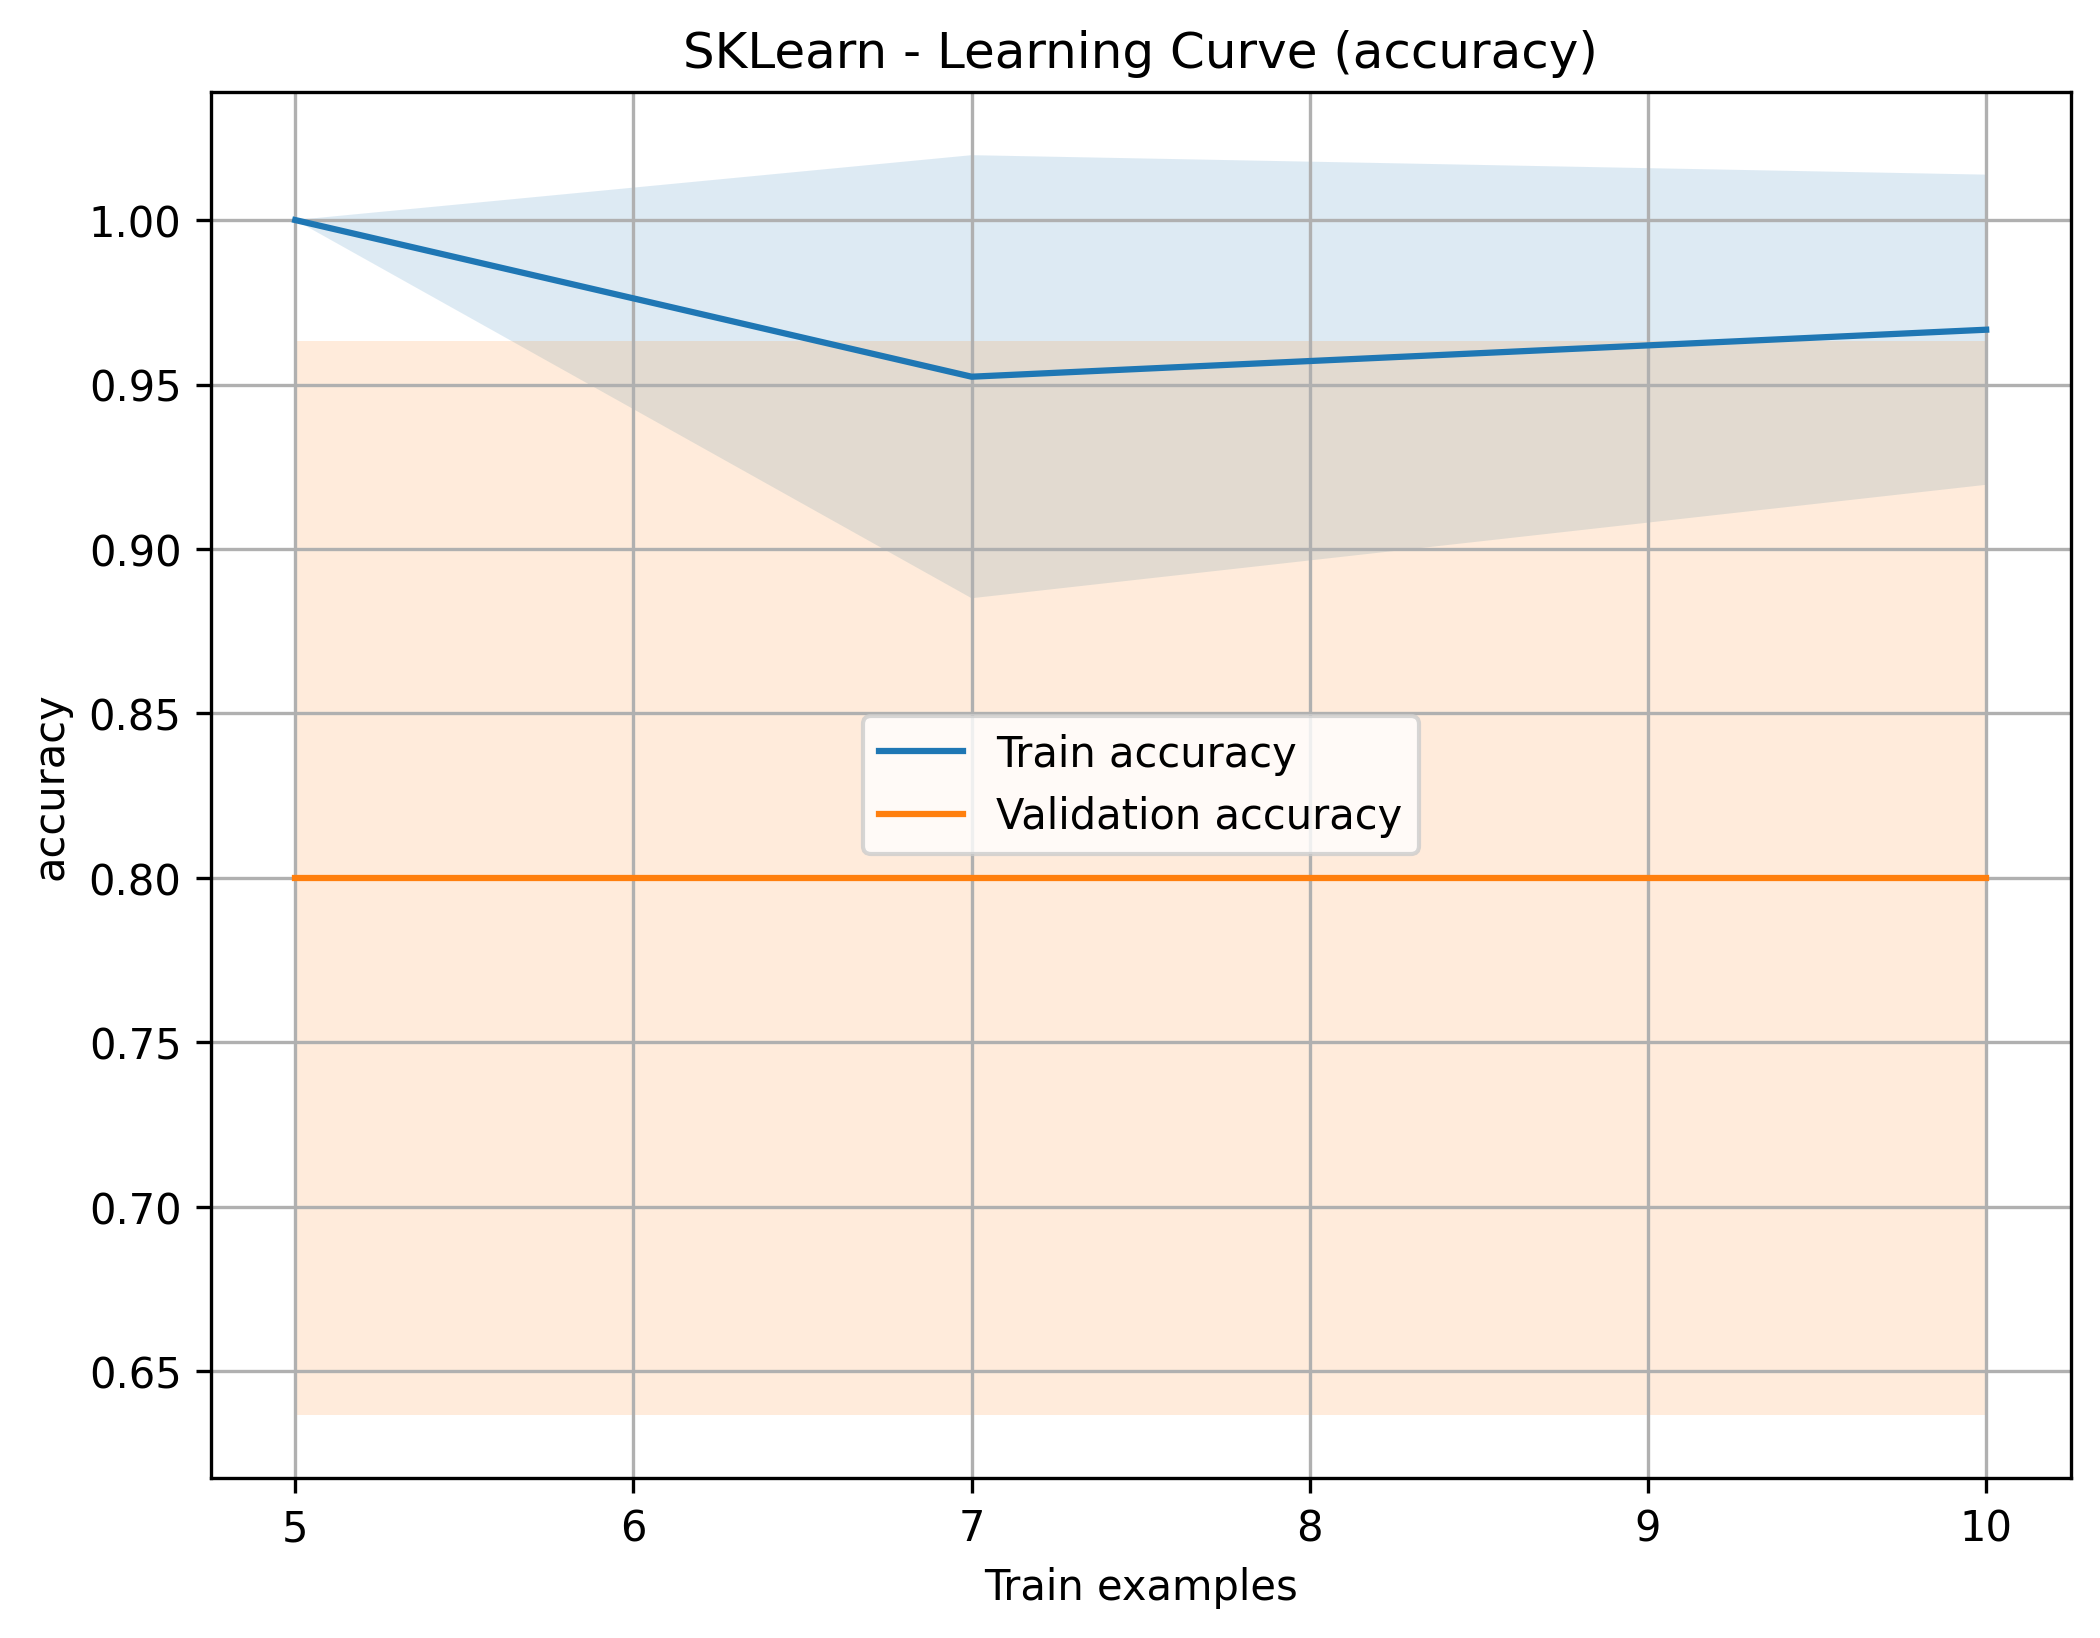

In [6]:

# CELDA 4 - Tracking y curvas con scikit-learn
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(.1, 1.0, 5), title=None):
    plt.figure(figsize=(8,6), dpi=300)
    title = title or "Learning Curve"
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='Train '+scoring)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
    plt.plot(train_sizes, val_mean, label='Validation '+scoring)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15)
    plt.title(title)
    plt.xlabel("Train examples")
    plt.ylabel(scoring)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_learning_curve(pipe_train, X_train_full, y_train_full, cv=3, scoring='accuracy', title="SKLearn - Learning Curve (accuracy)")


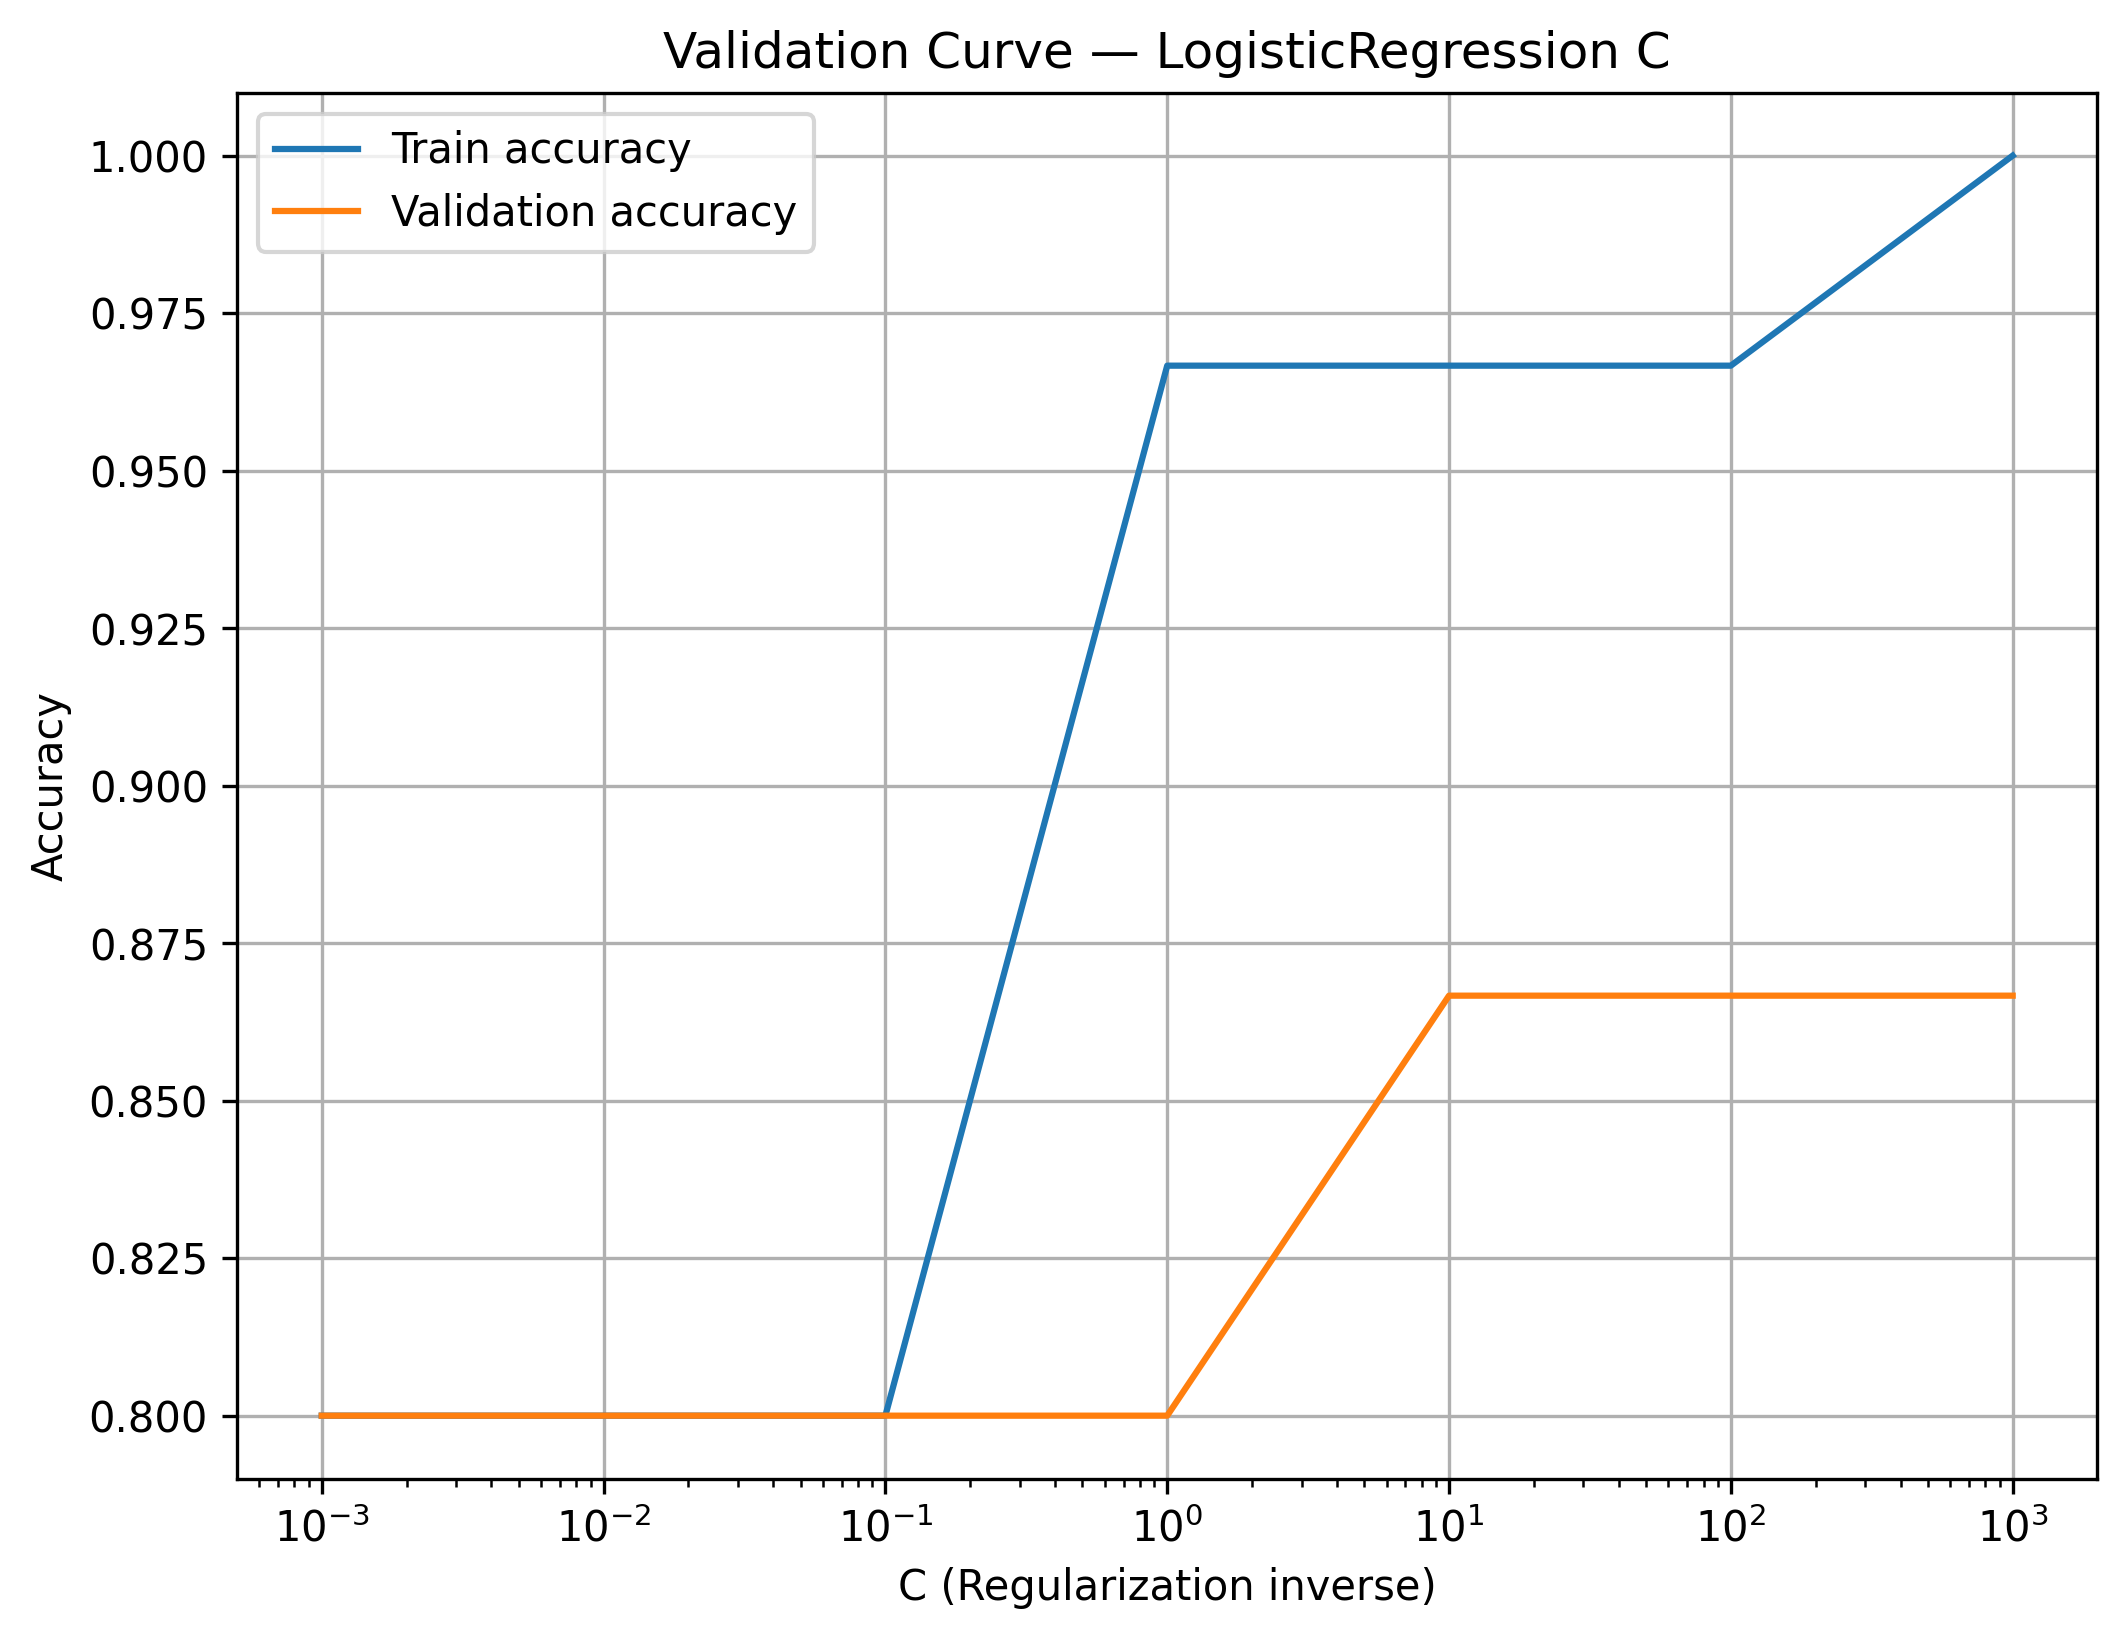

In [7]:

# CELDA 4b - Validation curve para hyperparam C
param_range = np.logspace(-3, 3, 7)
train_scores, val_scores = validation_curve(
    pipe_train, X_train_full, y_train_full,
    param_name="clf__C", param_range=param_range, cv=3, scoring="accuracy", n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,6), dpi=300)
plt.semilogx(param_range, train_mean, label="Train accuracy")
plt.semilogx(param_range, val_mean, label="Validation accuracy")
plt.xlabel("C (Regularization inverse)")
plt.ylabel("Accuracy")
plt.title("Validation Curve — LogisticRegression C")
plt.grid(True)
plt.legend()
plt.show()


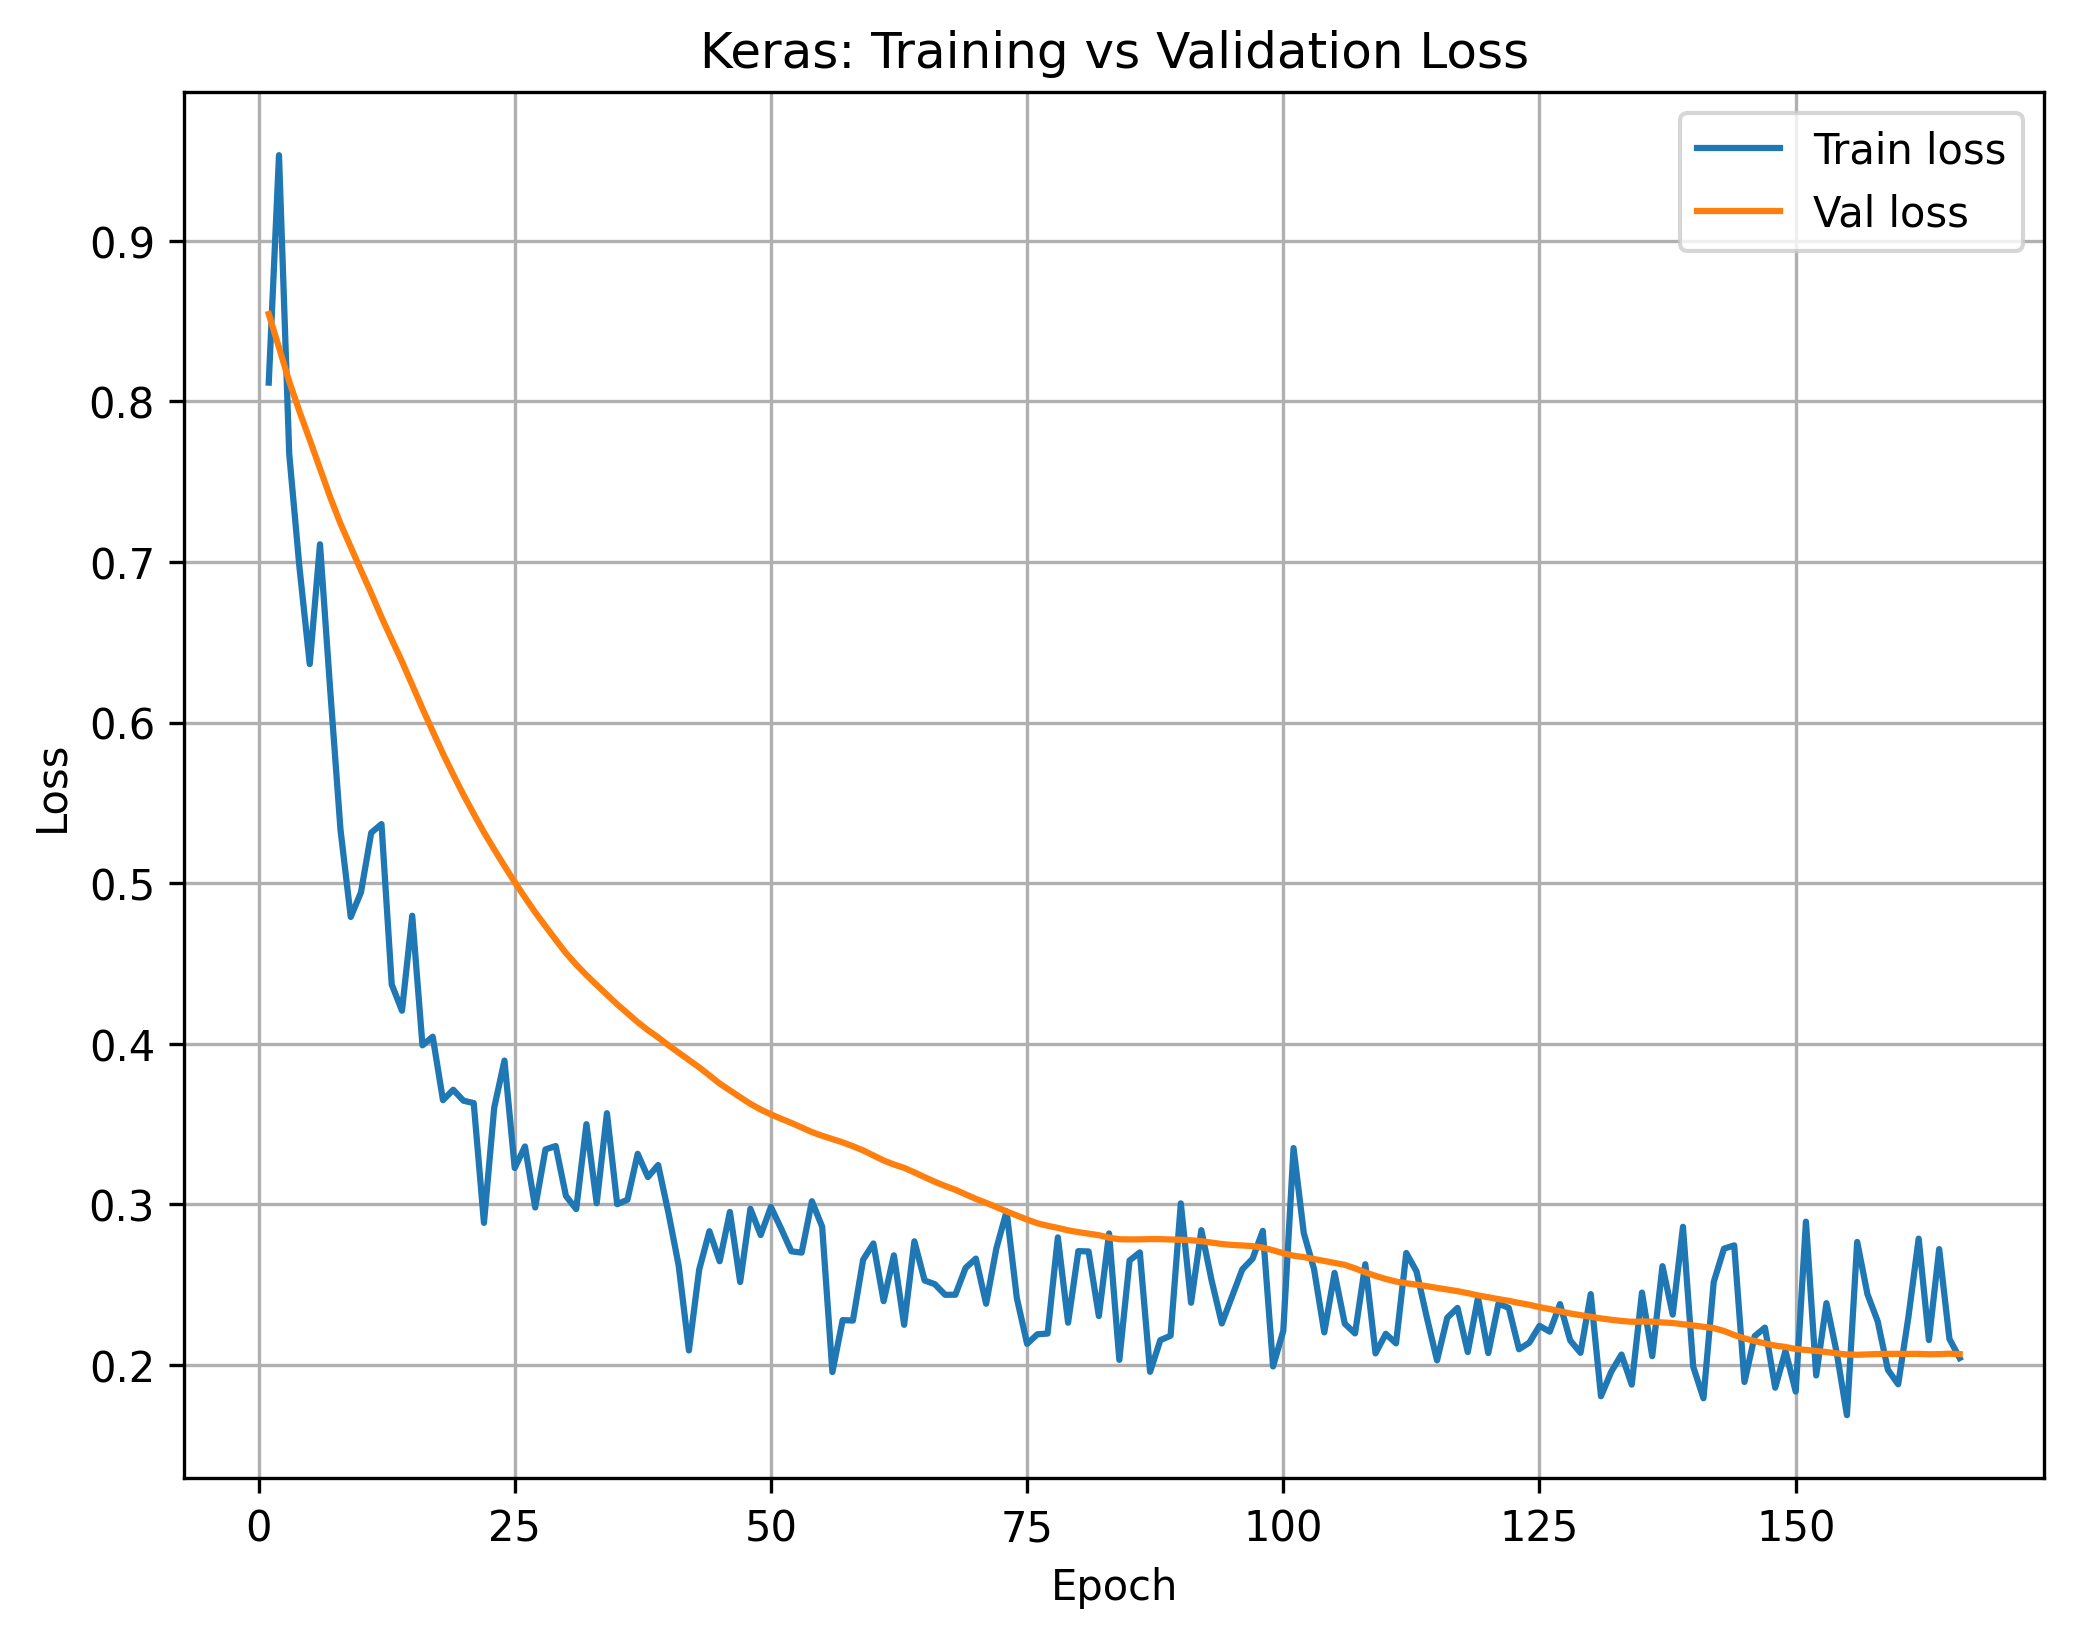

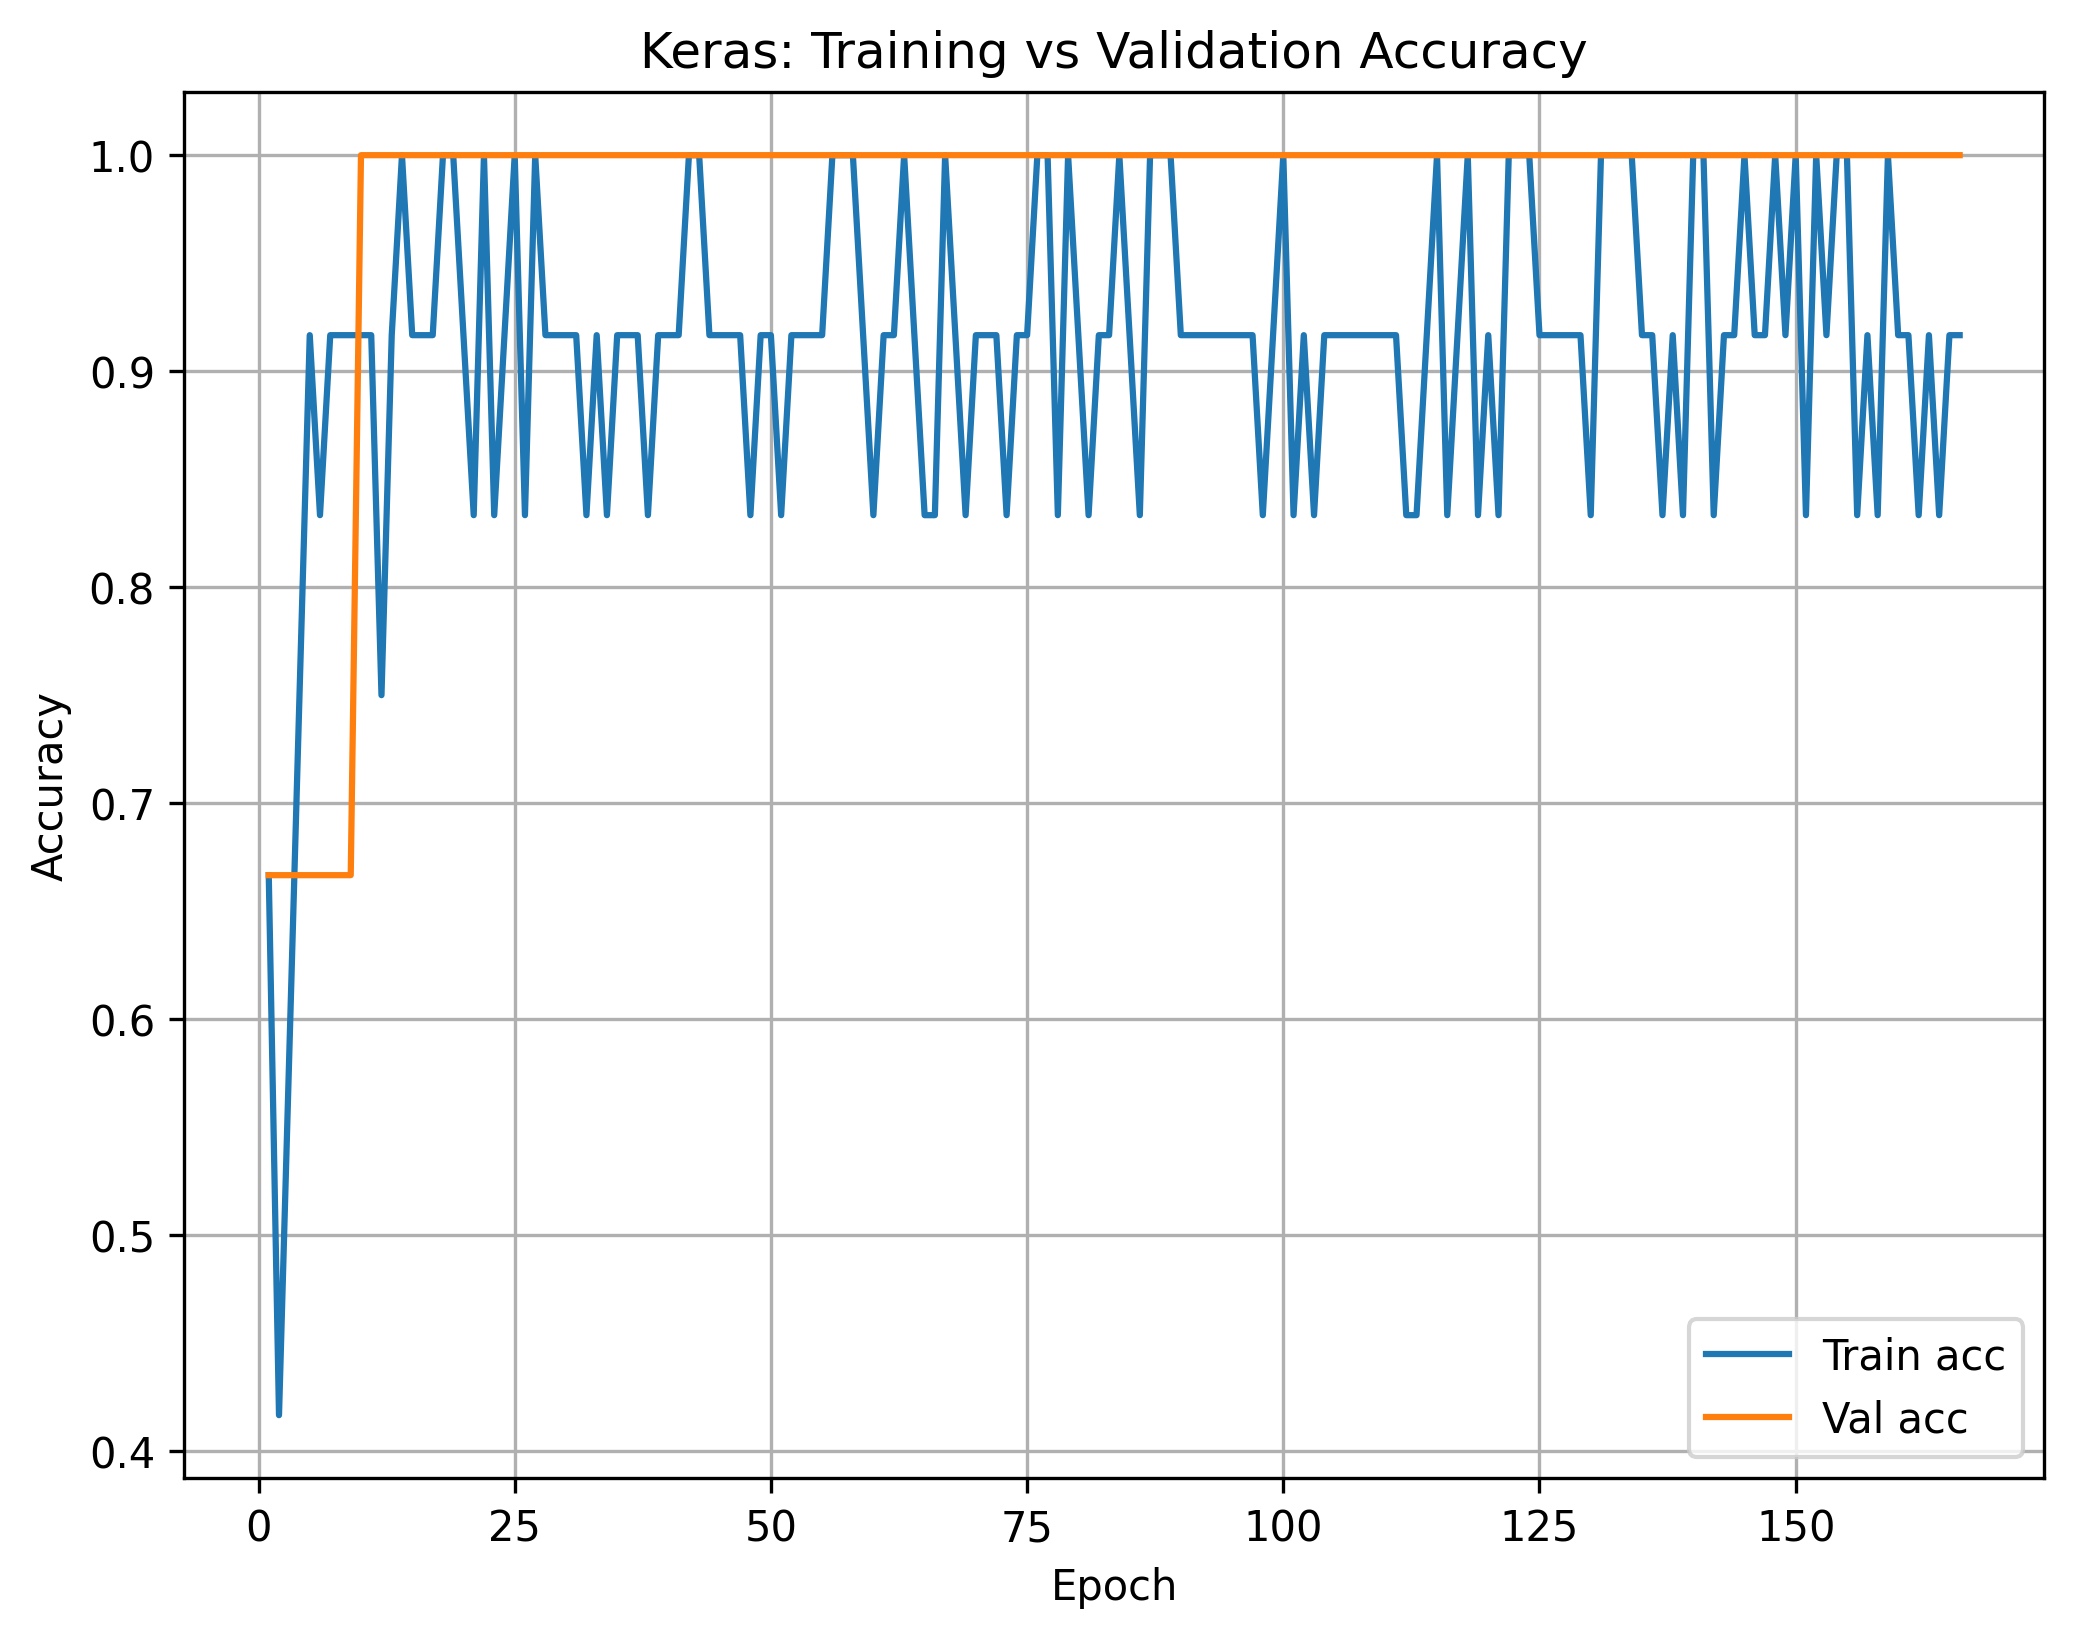

In [8]:

# CELDA 5 - TensorFlow / Keras model + callback personalizado
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import LabelEncoder

X_train_pp = preprocessor.fit_transform(X_train)
X_val_pp = preprocessor.transform(X_val)
X_test_pp = preprocessor.transform(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

def build_keras_model(input_shape, l2=1e-4, dropout=0.3):
    inp = layers.Input(shape=(input_shape,))
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    m = models.Model(inputs=inp, outputs=out)
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

model = build_keras_model(X_train_pp.shape[1], l2=1e-3, dropout=0.25)

class MetricLogger(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {"epoch": [], "loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.history["epoch"].append(epoch+1)
        self.history["loss"].append(logs.get("loss"))
        self.history["accuracy"].append(logs.get("accuracy"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_accuracy"].append(logs.get("val_accuracy"))

metric_logger = MetricLogger()
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = model.fit(X_train_pp, y_train_enc, epochs=200, batch_size=32,
                 validation_data=(X_val_pp, y_val_enc),
                 callbacks=[metric_logger, earlystop], verbose=0)

# plot
plt.figure(figsize=(8,6), dpi=300)
plt.plot(metric_logger.history["epoch"], metric_logger.history["loss"], label="Train loss")
plt.plot(metric_logger.history["epoch"], metric_logger.history["val_loss"], label="Val loss")
plt.title("Keras: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,6), dpi=300)
plt.plot(metric_logger.history["epoch"], metric_logger.history["accuracy"], label="Train acc")
plt.plot(metric_logger.history["epoch"], metric_logger.history["val_accuracy"], label="Val acc")
plt.title("Keras: Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


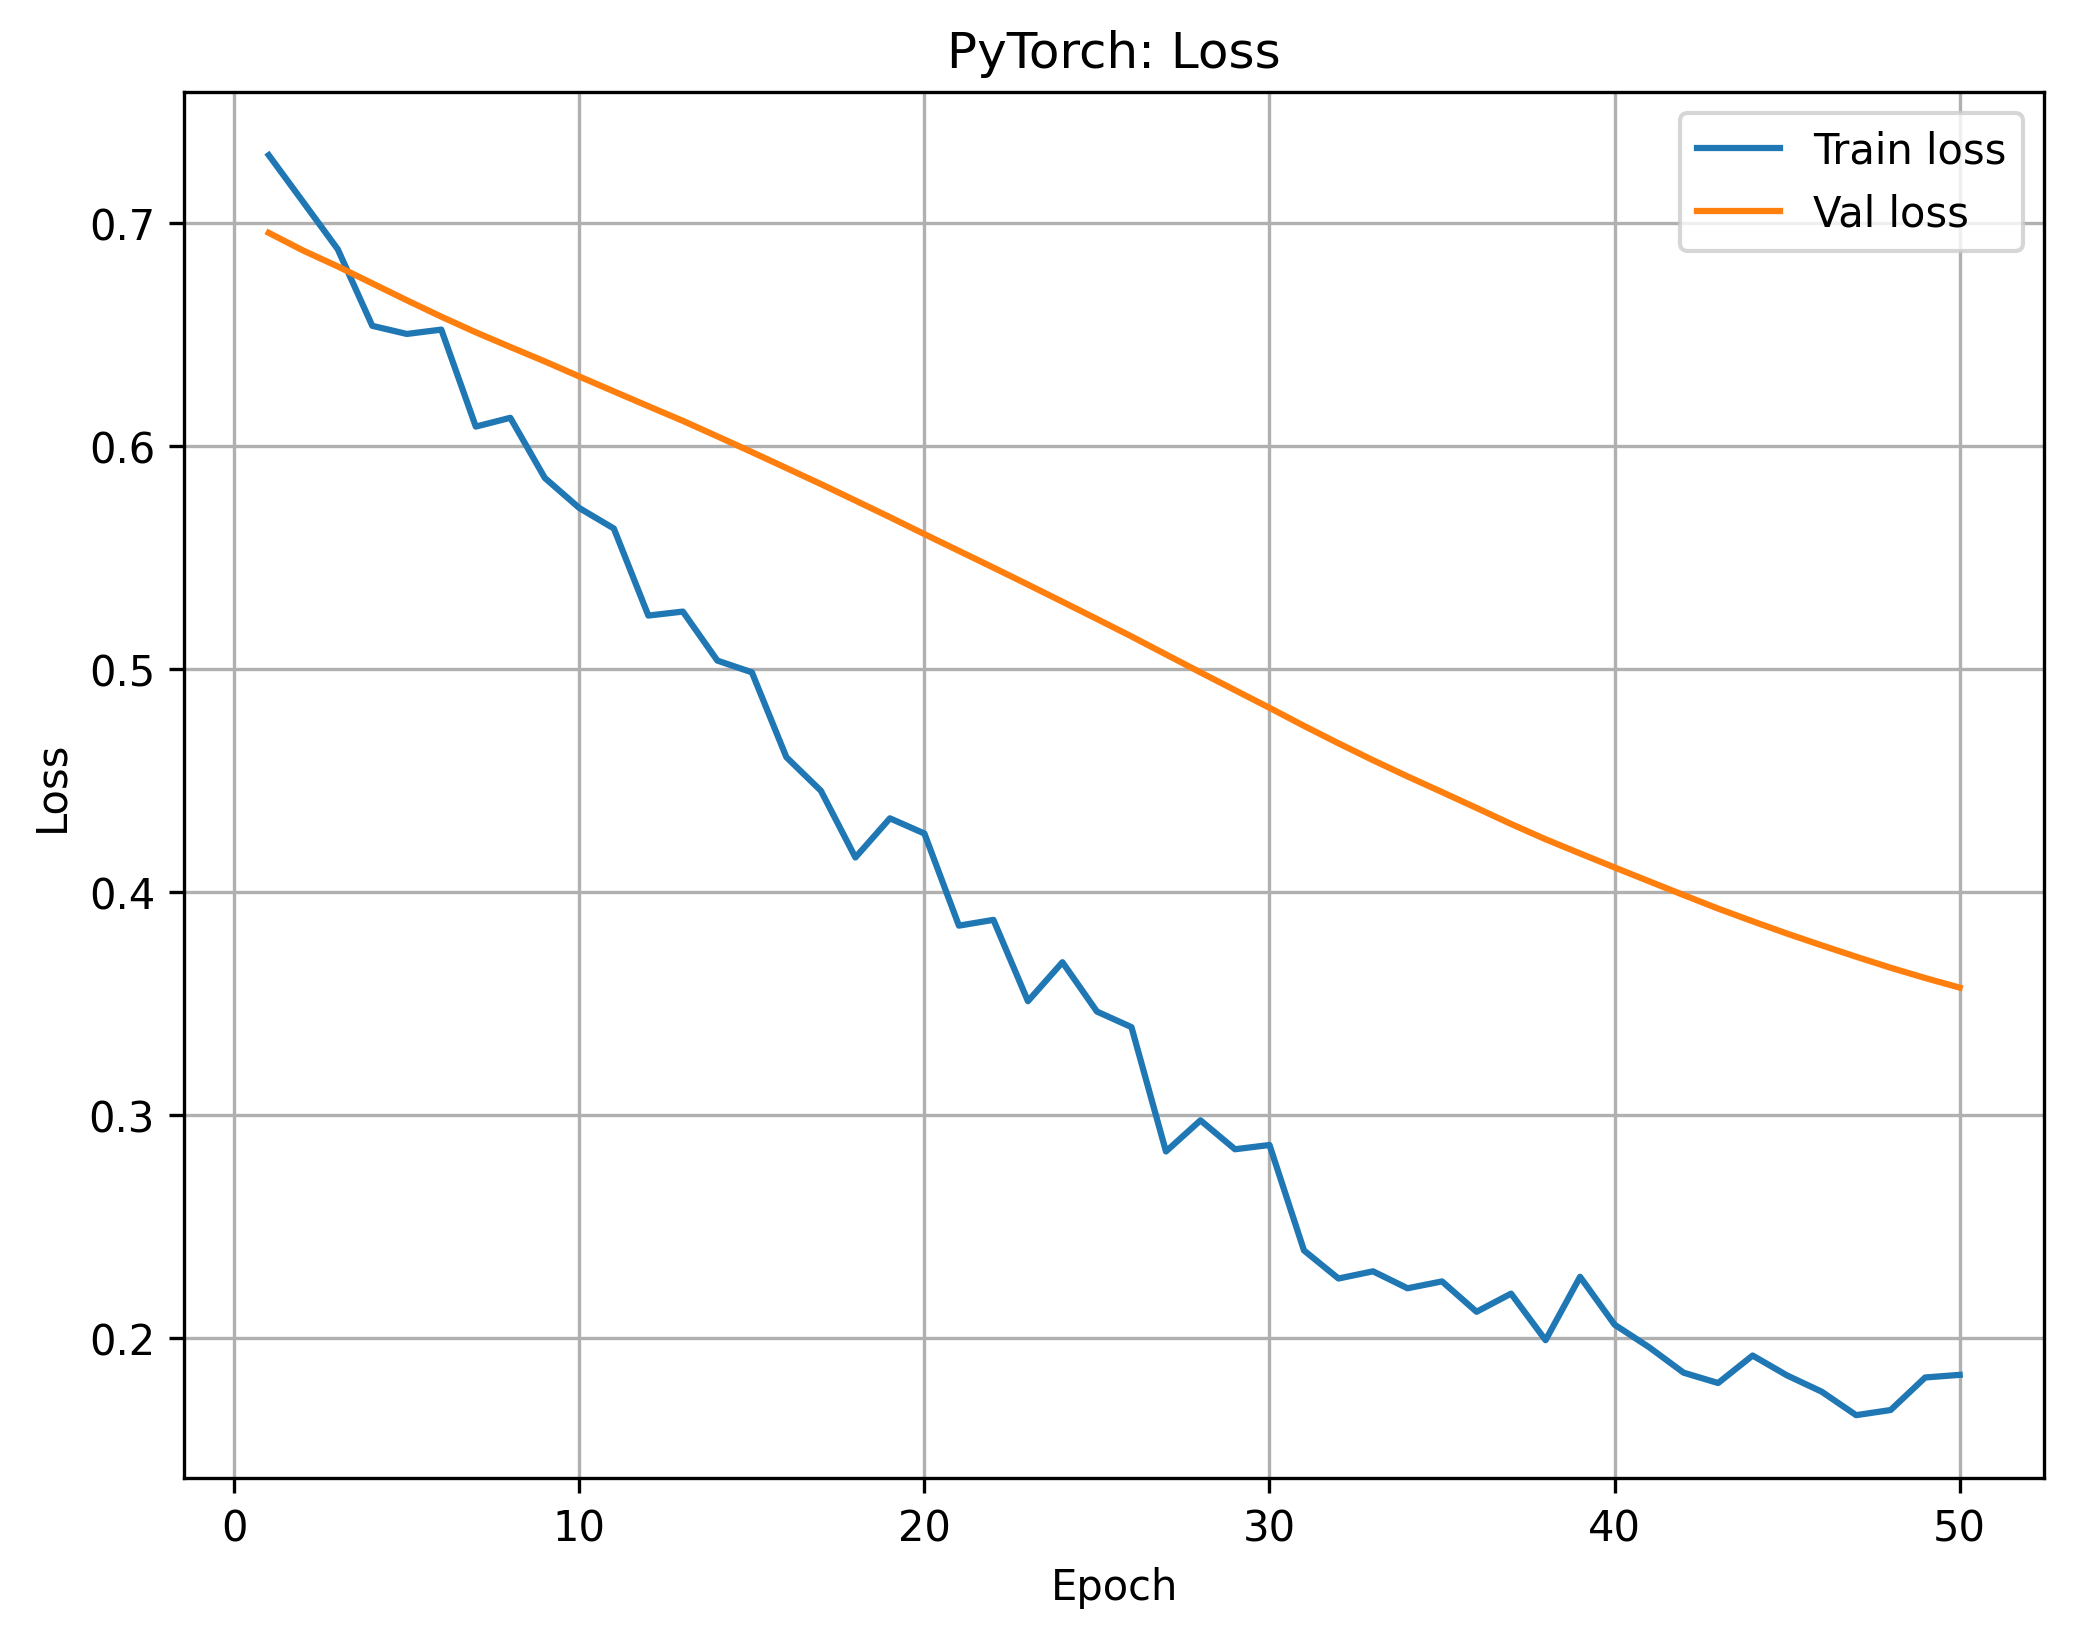

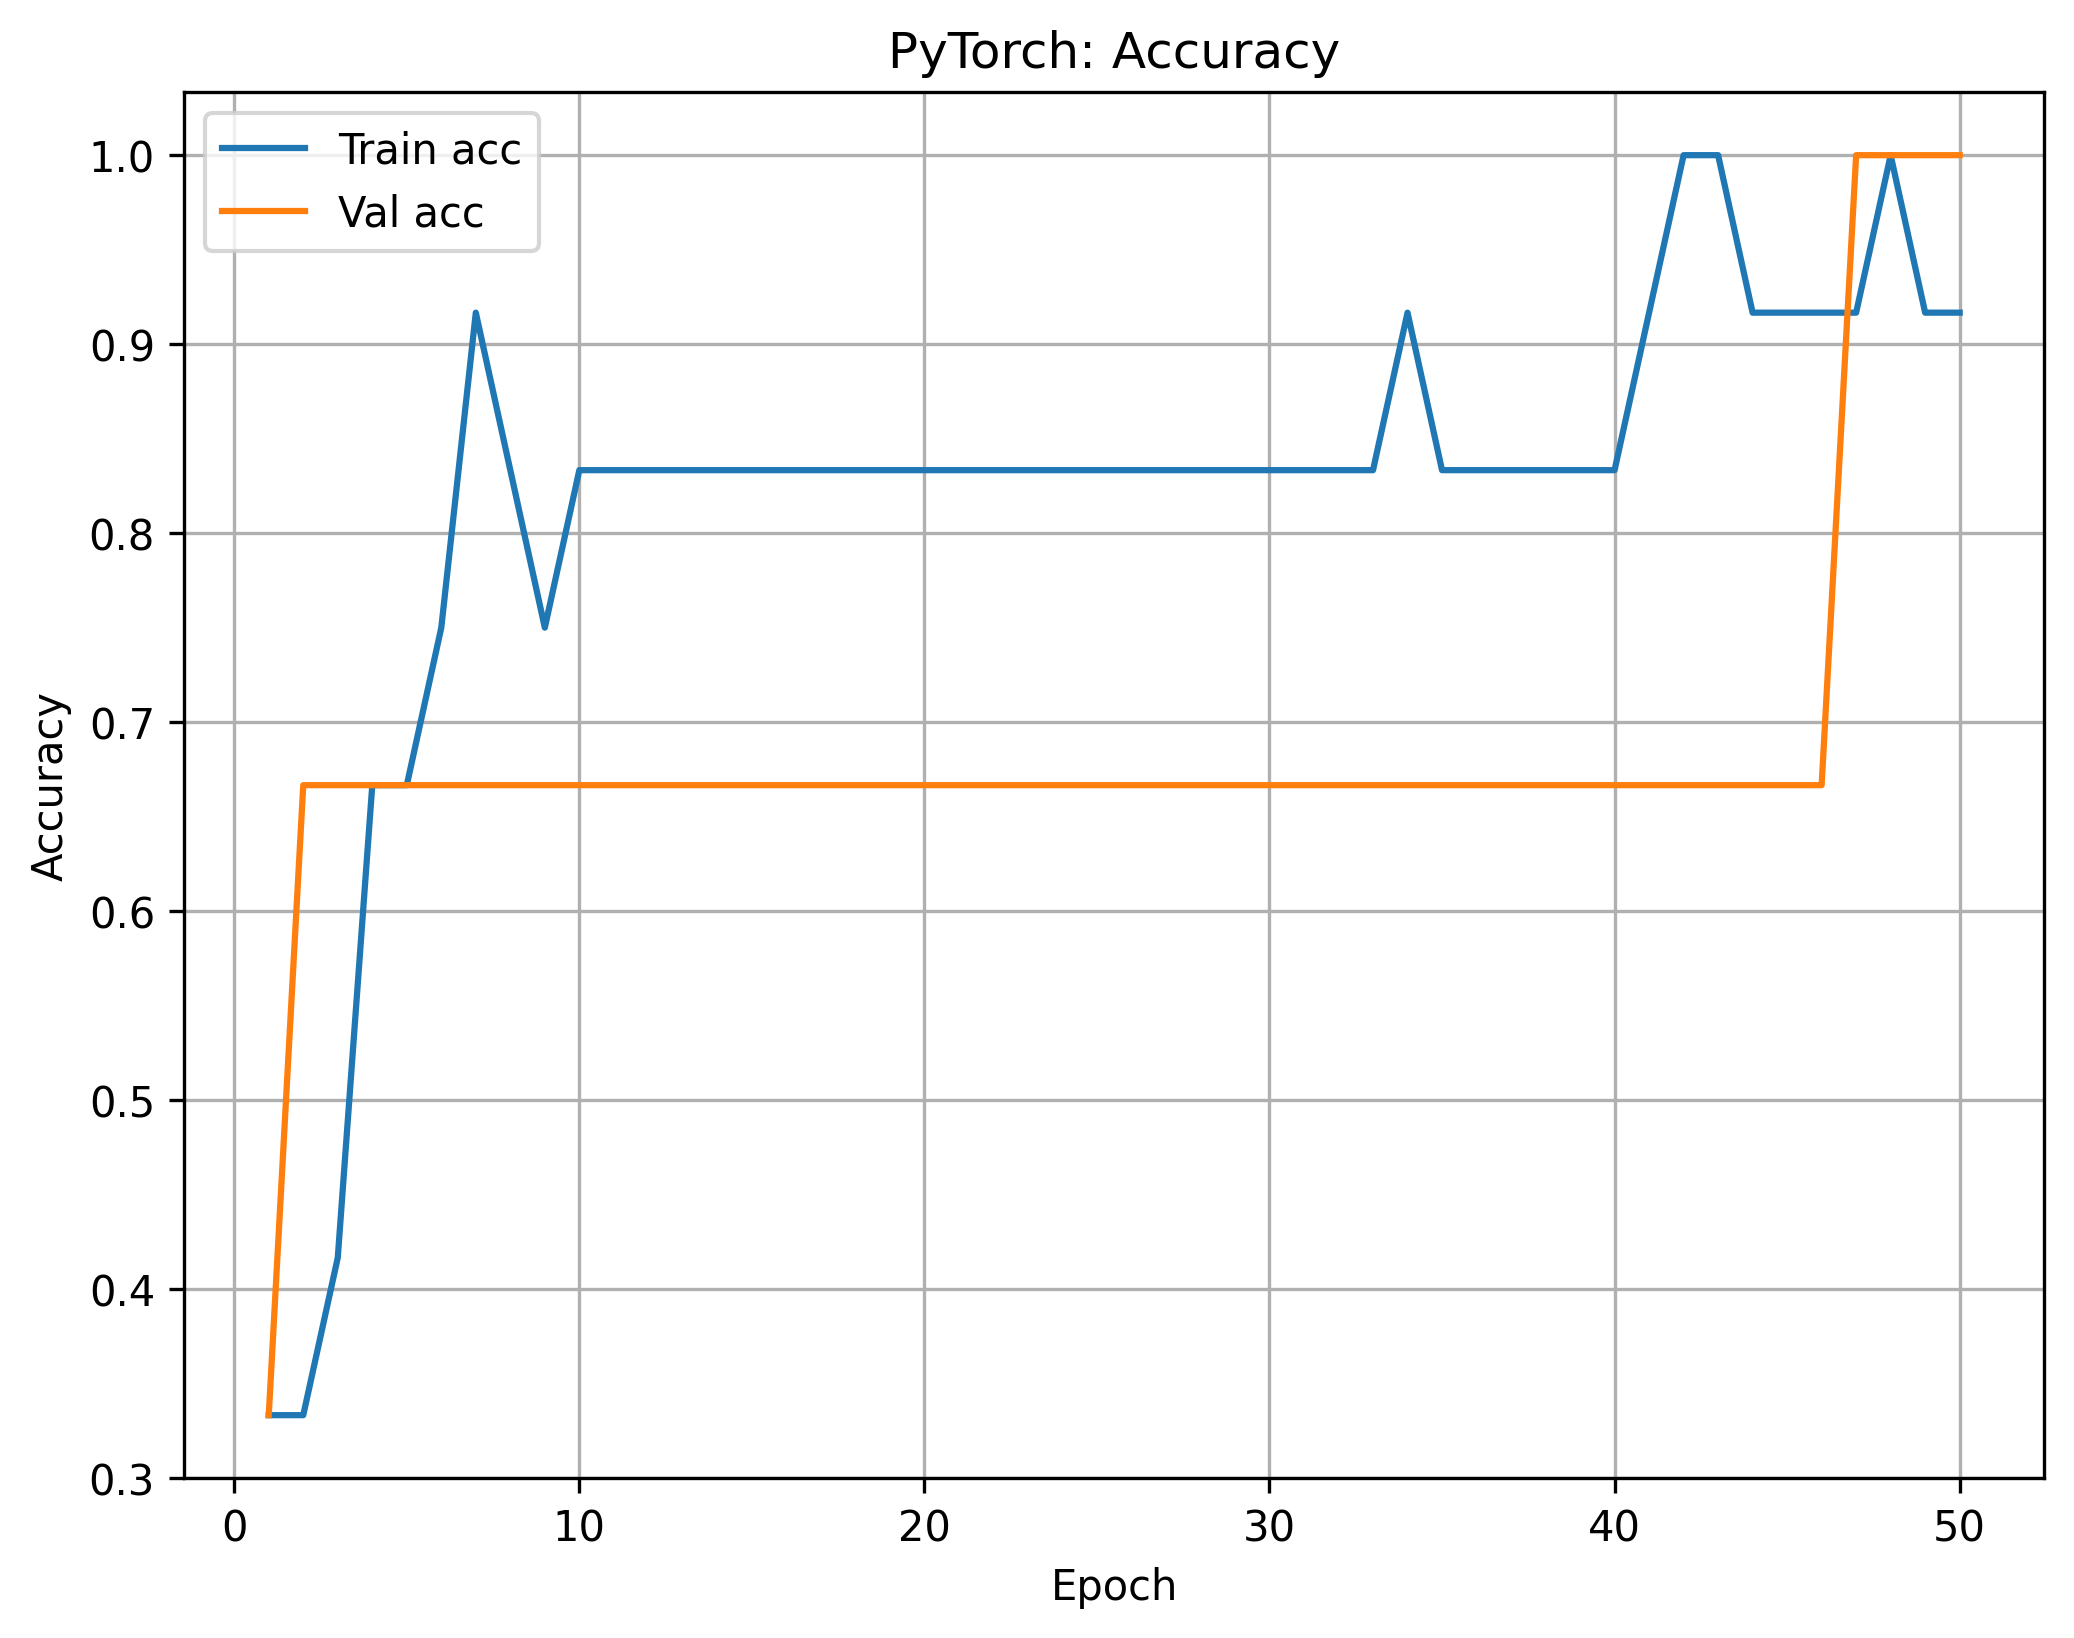

In [9]:

# CELDA 6 - PyTorch training loop
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_tr = torch.tensor(X_train_pp.astype(np.float32))
y_tr = torch.tensor(y_train_enc.astype(np.longlong))
X_va = torch.tensor(X_val_pp.astype(np.float32))
y_va = torch.tensor(y_val_enc.astype(np.longlong))

train_ds = TensorDataset(X_tr, y_tr)
val_ds = TensorDataset(X_va, y_va)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden=128, n_classes=num_classes, dropout=0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, n_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_t = MLP(X_tr.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_t.parameters(), lr=1e-3, weight_decay=1e-4)

log = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
EPOCHS = 50

for ep in range(1, EPOCHS+1):
    model_t.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model_t(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    train_loss = running_loss / total
    train_acc = correct / total

    model_t.eval()
    vloss = 0.0
    vcorrect = 0
    vtotal = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model_t(xb)
            loss = criterion(out, yb)
            vloss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            vcorrect += (preds == yb).sum().item()
            vtotal += xb.size(0)
    val_loss = vloss / vtotal
    val_acc = vcorrect / vtotal

    log["epoch"].append(ep)
    log["train_loss"].append(train_loss)
    log["train_acc"].append(train_acc)
    log["val_loss"].append(val_loss)
    log["val_acc"].append(val_acc)

plt.figure(figsize=(8,6), dpi=300)
plt.plot(log["epoch"], log["train_loss"], label="Train loss")
plt.plot(log["epoch"], log["val_loss"], label="Val loss")
plt.title("PyTorch: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,6), dpi=300)
plt.plot(log["epoch"], log["train_acc"], label="Train acc")
plt.plot(log["epoch"], log["val_acc"], label="Val acc")
plt.title("PyTorch: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [10]:

# CELDA 7 - Diagnóstico automático
import numpy as np

def diagnose_from_curves(train_loss, val_loss, train_acc=None, val_acc=None, loss_tol=0.02):
    res = {}
    res["train_loss_last"] = train_loss[-1]
    res["val_loss_last"] = val_loss[-1]
    res["loss_gap"] = np.mean(np.array(train_loss) - np.array(val_loss))
    if train_acc and val_acc:
        res["train_acc_last"] = train_acc[-1]
        res["val_acc_last"] = val_acc[-1]
        res["acc_gap"] = np.mean(np.array(train_acc) - np.array(val_acc))
    if np.mean(train_loss[-5:]) < np.mean(train_loss[:5]) and np.mean(val_loss[-5:]) > np.mean(val_loss[:5]):
        diagnosis = "OVERFITTING"
    elif res["loss_gap"] < loss_tol and res["val_loss_last"] > 1.0:
        diagnosis = "UNDERFITTING"
    else:
        diagnosis = "OPTIMAL_OR_MIXED"
    res["diagnosis"] = diagnosis
    return res

# Ejemplo con métricas de Keras
if 'metric_logger' in globals():
    diag = diagnose_from_curves(metric_logger.history["loss"], metric_logger.history["val_loss"],
                                metric_logger.history["accuracy"], metric_logger.history["val_accuracy"])
    print("Diagnóstico:", diag["diagnosis"])
    diag


Diagnóstico: OPTIMAL_OR_MIXED


In [11]:

# CELDA 8 - Estrategias de mejora
def recommend_strategies(diagnosis):
    if diagnosis == "OVERFITTING":
        return [
            "Aumentar regularización (L1/L2, dropout)",
            "Aplicar EarlyStopping (ya implementado en Keras)",
            "Data augmentation o más datos",
            "Reducir complejidad del modelo",
            "Validación cruzada más rigurosa"
        ]
    elif diagnosis == "UNDERFITTING":
        return [
            "Aumentar complejidad del modelo",
            "Reducir regularización",
            "Feature engineering o más características",
            "Más épocas de entrenamiento",
            "Optimizadores más sofisticados"
        ]
    else:
        return [
            "Gap estable entre entrenamiento y validación",
            "Si se requiere mejorar: tuning de hiperparámetros",
            "Revisar métricas de negocio"
        ]

if 'diag' in globals():
    recs = recommend_strategies(diag["diagnosis"])
    print("Recomendaciones para", diag["diagnosis"], ":")
    for r in recs:
        print(" -", r)


Recomendaciones para OPTIMAL_OR_MIXED :
 - Gap estable entre entrenamiento y validación
 - Si se requiere mejorar: tuning de hiperparámetros
 - Revisar métricas de negocio
